In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy import stats
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
import geopandas as gpd

sns.set_theme(style='whitegrid')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
DATA_PATH = '/home/georgetz/Desktop/Classes/Spring 2024/DSC 394 - Data Science Project/Final Project'

In [25]:
train = pd.read_csv('train.csv')
print(f"Shape: {train.shape}")
train.head()

Shape: (13173, 152)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
2,277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
3,320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
4,190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


In [6]:
test = pd.read_csv('test.csv')
print(f"Shape: {test.shape}")
test.head()

Shape: (5646, 151)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
0,730681,NaN,COMMERCIAL,LA,713,South,West South Central,55,F,NaN,...,62.21,62.23,78.34,81.96,83.58,82.22,80.20,69.73,53.14,51.34
1,334212,Black,NaN,NC,283,South,South Atlantic,60,F,40.00,...,48.63,58.14,77.26,80.05,82.88,82.09,78.85,64.60,50.57,48.10
2,571362,NaN,COMMERCIAL,TX,794,South,West South Central,54,F,32.33,...,57.82,59.95,77.79,82.45,82.44,80.77,72.16,59.31,48.25,42.13
3,907331,NaN,COMMERCIAL,TN,373,South,East South Central,63,F,27.07,...,47.57,53.50,71.31,75.20,76.96,75.78,74.87,61.06,44.31,42.83
4,208382,Asian,NaN,WA,980,West,Pacific,62,F,NaN,...,41.02,46.25,56.92,57.88,66.16,65.21,57.52,49.53,43.75,38.33


In [26]:
breast_cancer_diagnosis_df = train[['breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc']].drop_duplicates()
breast_cancer_diagnosis_df.head()

,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc
0,C50912,Malignant neoplasm of unspecified site of left...
1,C50412,Malig neoplasm of upper-outer quadrant of left...
2,1749,"Malignant neoplasm of breast (female), unspeci..."
3,C50911,Malignant neoplasm of unsp site of right femal...
4,1748,Malignant neoplasm of other specified sites of...


In [ ]:
breast_cancer_diagnosis_df.to_csv('diagnosis_codes.csv', index=False)

### Get feature descriptions

In [ ]:
with open('descriptions.txt', 'r') as f:
    descs = f.readlines()

In [ ]:
features = []
descriptions = []
for line in descs:
    values = line.split('-', maxsplit=1)
    features.append(values[0].strip())
    descriptions.append(values[1].strip())
    

In [ ]:
desc_df = pd.DataFrame({'Feature': features, 'Description': descriptions})
desc_df.head()

In [7]:
def get_colnames():
    return list(train.columns)

In [ ]:
# desc_df.to_excel('desc.xlsx', index=False)

In [ ]:
print(pd.DataFrame({'train.csv': train.shape, 'test.csv':test.shape}, index=['# of rows', '# of cols']).to_latex(escape=False, caption='Dimensions of training and testing set.', label='tab:dataset_dimensions', longtable=False, column_format='|c|c|c|'))

In [11]:
def detect_column_type(column):
    if pd.api.types.is_numeric_dtype(column):
        return 'Numeric'
    elif pd.api.types.is_datetime64_any_dtype(column):
        return 'Datetime'
    elif pd.api.types.is_string_dtype(column):
        return 'Categorical'  # assuming textual data are categories
    elif pd.api.types.is_bool_dtype(column):
        return 'Boolean'
    else:
        return 'Other'

In [12]:
train.apply(detect_column_type).value_counts()

Numeric        141
Categorical     11
dtype: int64

In [13]:
print(train.shape)
train.isnull().sum().sort_values(ascending=False)[train.isnull().sum().sort_values(ascending=False) != 0]

(13173, 152)


metastatic_first_novel_treatment_type    13162
metastatic_first_novel_treatment         13162
bmi                                       9071
patient_race                              6657
payer_type                                1765
                                         ...  
Average of May-13                            3
Average of Nov-16                            3
Average of Feb-13                            3
Average of Dec-13                            3
Average of Jun-17                            1
Length: 72, dtype: int64

In [14]:
print(test.shape)
test.isnull().sum().sort_values(ascending=False)

(5646, 151)


metastatic_first_novel_treatment_type    5639
metastatic_first_novel_treatment         5639
bmi                                      3941
patient_race                             2785
payer_type                                785
                                         ... 
rent_burden                                 0
education_less_highschool                   0
education_highschool                        0
education_some_college                      0
limited_english                             0
Length: 151, dtype: int64

### Exploratory Data Analysis

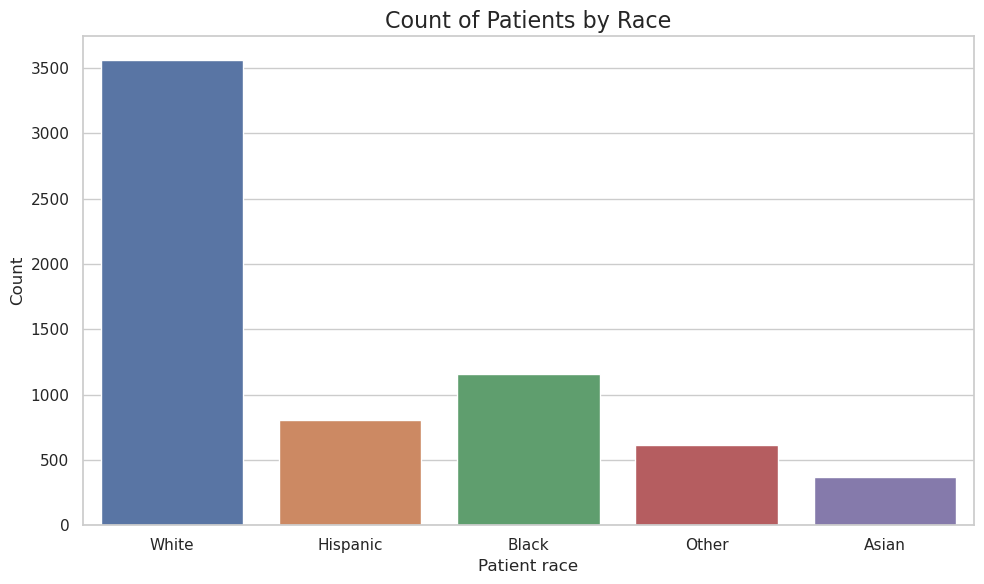

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=train, x='patient_race', ax=ax)
ax.set_xlabel('Patient race', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Count of Patients by Race', fontsize=16)
fig.tight_layout()
# fig.savefig(os.path.join(DATA_PATH, 'images', 'count_by_race.png'))
plt.show()

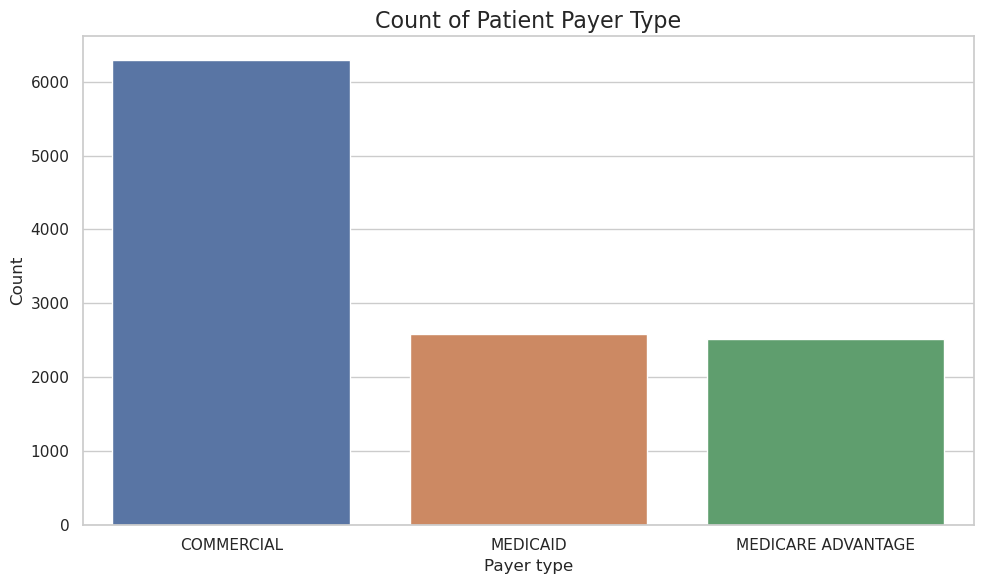

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=train, x='payer_type', ax=ax)
ax.set_xlabel('Payer type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Count of Patient Payer Type', fontsize=16)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'count_by_payer_type.png'))
plt.show()

In [77]:
state_counts = train['patient_state'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

fig = px.choropleth(state_counts,
                    locations='State',
                    locationmode="USA-states",
                    color='Count',
                    color_continuous_scale='Blues', # Viridis
                    scope="usa",
                    title='Count of Patients by State')
fig.update_layout(
    title={
        'text': "Count of Patients by State",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',},
    title_font=dict(size=24)  # Setting title font size
)
# Adding annotations for each state with counts
for idx, row in state_counts.iterrows():
    fig.add_annotation(
        x=row['State'],
        y=row['Count'],
        text=str(row['Count']),
        showarrow=False,
        font=dict(size=10, color="white"),  # Adjust font size and color as needed
        xanchor='center'  # Ensures text is centered
    )
fig.write_html(os.path.join(DATA_PATH, 'images', 'patient_count_by_state.html'))


0.15670648207593144

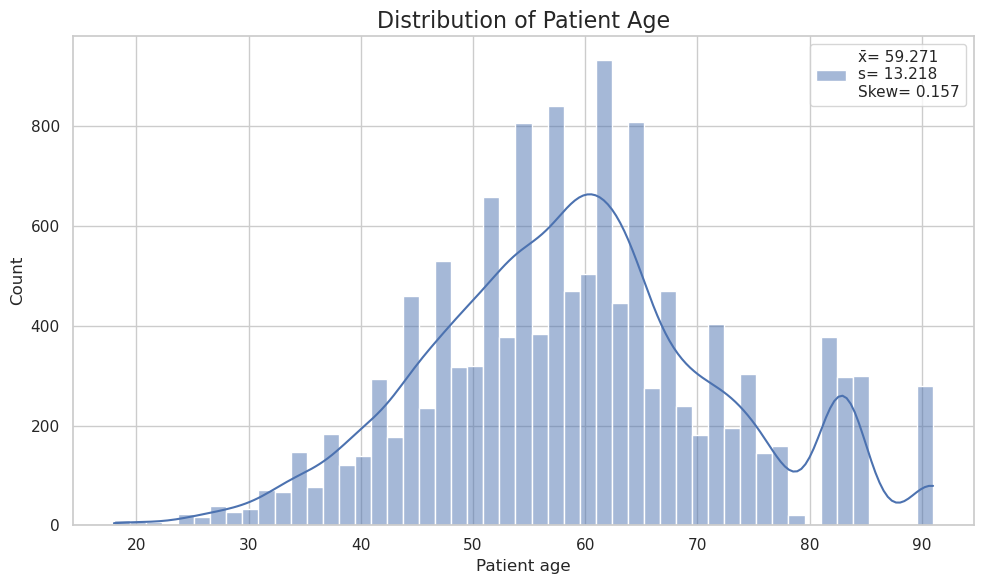

In [90]:
fig, ax = plt.subplots(figsize=(10,6))
skewness = np.round(stats.skew(train.patient_age), 3)
mean_value = np.round(np.mean(train.patient_age), 3)
st_dev = np.round(np.std(train.patient_age), 3)
sns.histplot(data=train, x='patient_age', kde=True, label=f"x̄= {mean_value}\ns= {st_dev}\nSkew= {skewness}")
ax.legend()
ax.set_title('Distribution of Patient Age', fontsize=16)
ax.set_xlabel('Patient age', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'age_dist.png'))
plt.show()


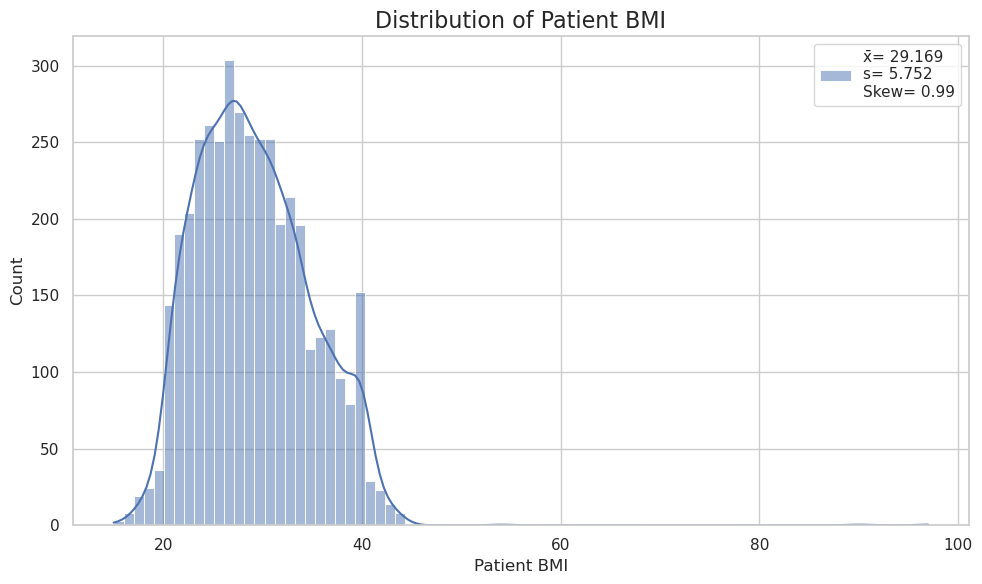

In [221]:
fig, ax = plt.subplots(figsize=(10,6))
skewness = np.round(stats.skew(train.bmi, nan_policy='omit'), 3)
mean_value = np.round(np.mean(train.bmi), 3)
st_dev = np.round(np.std(train.bmi), 3)
sns.histplot(data=train, x='bmi', kde=True, label=f"x̄= {mean_value}\ns= {st_dev}\nSkew= {skewness}")
ax.legend()
ax.set_title('Distribution of Patient BMI', fontsize=16)
ax.set_xlabel('Patient BMI', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'bmi_dist.png'))
plt.show()


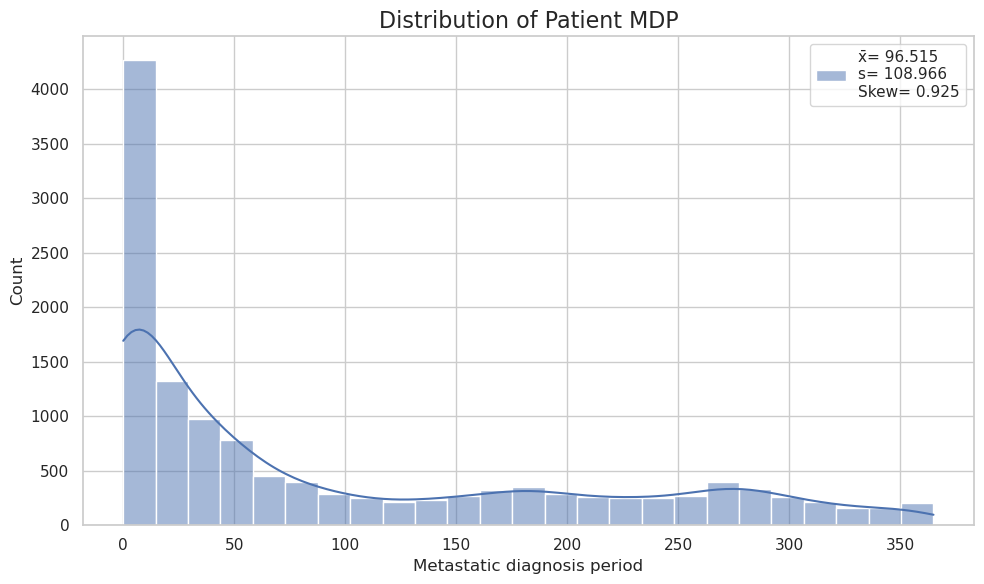

In [222]:
fig, ax = plt.subplots(figsize=(10,6))
skewness = np.round(stats.skew(train.metastatic_diagnosis_period, nan_policy='omit'), 3)
mean_value = np.round(np.mean(train.metastatic_diagnosis_period), 3)
st_dev = np.round(np.std(train.metastatic_diagnosis_period), 3)
sns.histplot(data=train, x='metastatic_diagnosis_period', kde=True, label=f"x̄= {mean_value}\ns= {st_dev}\nSkew= {skewness}")
ax.legend()
ax.set_title('Distribution of Patient MDP', fontsize=16)
ax.set_xlabel('Metastatic diagnosis period', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'mdp_dist.png'))
plt.show()


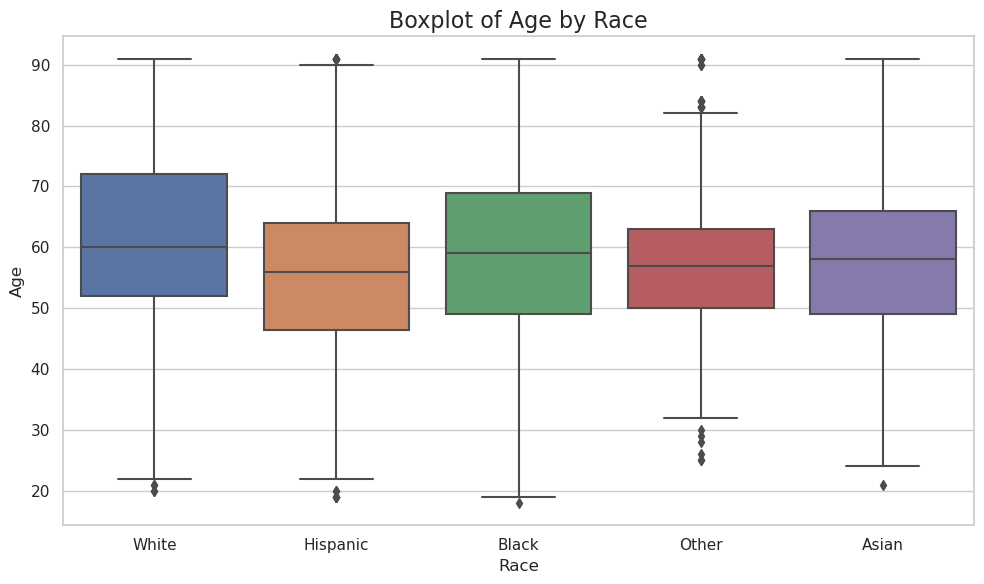

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=train, y='patient_age', x='patient_race')
ax.set_title('Boxplot of Age by Race', fontsize=16)
ax.set_xlabel('Race', fontsize=12)
ax.set_ylabel('Age', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'age_boxplot_by_race.png'))
plt.show()

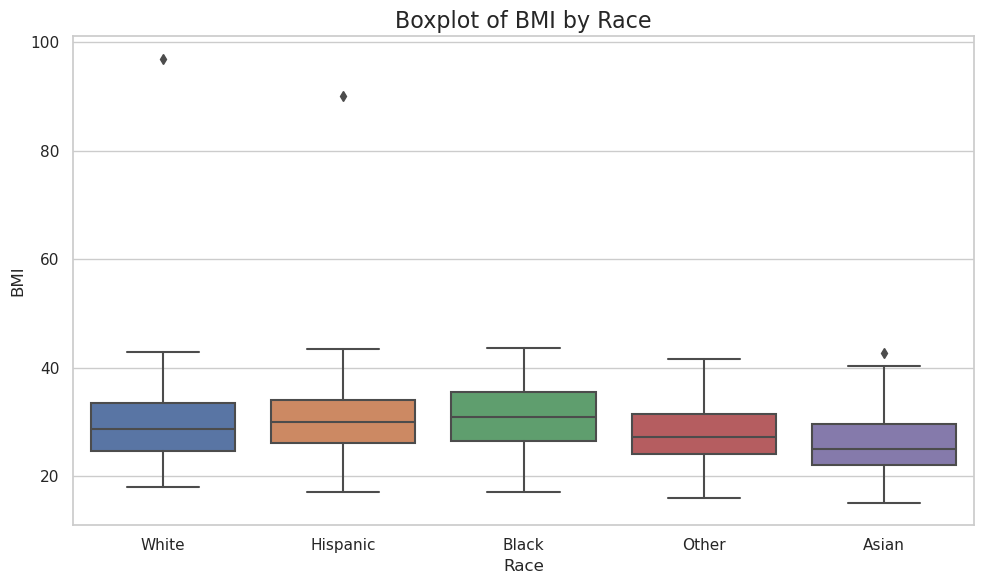

In [235]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=train, y='bmi', x='patient_race')
ax.set_title('Boxplot of BMI by Race', fontsize=16)
ax.set_xlabel('Race', fontsize=12)
ax.set_ylabel('BMI', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'bmi_boxplot_by_race.png'))
plt.show()

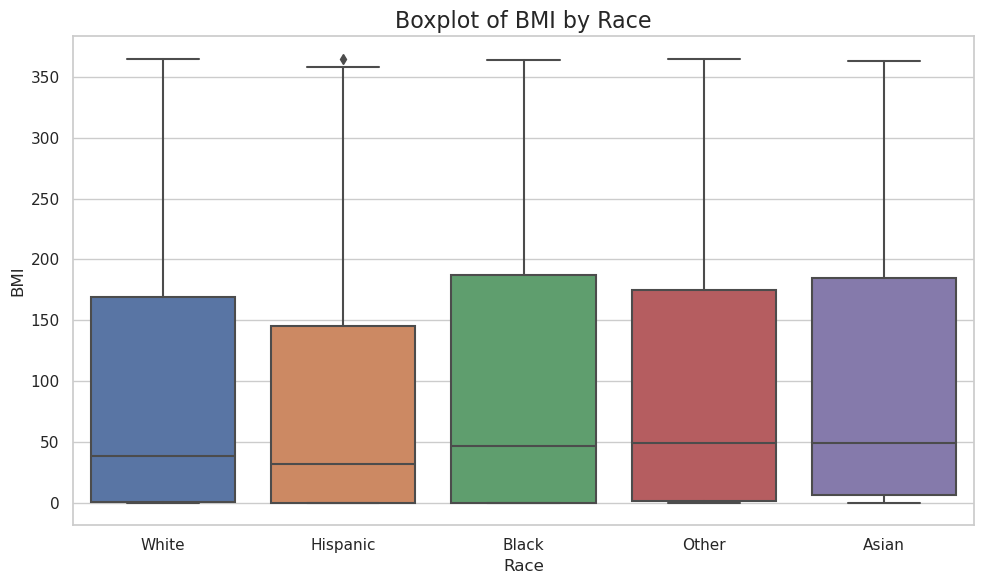

In [225]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=train, y='metastatic_diagnosis_period', x='patient_race')
ax.set_title('Boxplot of BMI by Race', fontsize=16)
ax.set_xlabel('Race', fontsize=12)
ax.set_ylabel('BMI', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'mdp_boxplot_by_race.png'))
plt.show()

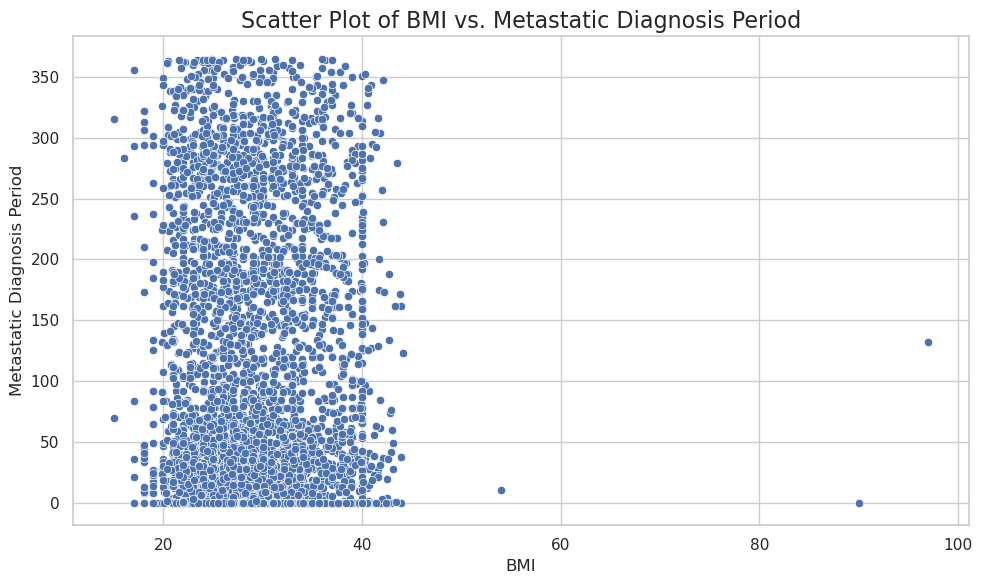

In [113]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=train, x='bmi', y='metastatic_diagnosis_period', ax=ax, alpha=1)
ax.set_title('Scatter Plot of BMI vs. Metastatic Diagnosis Period', fontsize=16)
ax.set_xlabel('BMI', fontsize=12)
ax.set_ylabel('Metastatic Diagnosis Period', fontsize=12)
plt.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'bmi_diag_period_scatter_plot.png'))
plt.show()

In [ ]:
cat_features = train.describe(include='object').columns
num_features = train.describe(exclude='object').columns
train_transformed = pd.get_dummies(train, columns=cat_features)

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
# train2 = pd.DataFrame(scaler.fit_transform(train2), columns = train2.columns)
train_transformed.head()

In [ ]:
test_transformed = pd.get_dummies(test, columns=cat_features)
test_transformed.head()

In [ ]:
missing_statistics = train.isnull().sum().sort_values(ascending=False)[train.isnull().sum().sort_values(ascending=False) != 0]
missing_statistics

In [ ]:
missing_vars_train = train.columns[train.isnull().any()].tolist()
print(missing_vars_train)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train[missing_vars_train].isnull(), cbar=False, cmap='viridis', ax=ax)
ax.set_title('Features w/ Missing Data (Train)', fontsize=16)
ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Data points', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'missing_train.png'))
plt.show()

In [ ]:
missing_vars_test = test.columns[test.isnull().any()].tolist()
print(missing_vars_test)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(test[missing_vars_test].isnull(), cbar=False, cmap='viridis', ax=ax)
ax.set_title('Features w/ Missing Data (Test)', fontsize=16)
ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Data points', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'missing_test.png'))
plt.show()

### Remove features with missing data

In [260]:
train.drop(columns=['metastatic_first_novel_treatment_type', 'metastatic_first_novel_treatment', 'breast_cancer_diagnosis_desc'], inplace=True)
test.drop(columns=['metastatic_first_novel_treatment_type', 'metastatic_first_novel_treatment', 'breast_cancer_diagnosis_desc'], inplace=True)

 ### Correlation Matrix for Missing Values:
#### train.isnull().corr() calculates the correlation matrix for missing values. This matrix shows the pairwise correlations between variables with missing values.
#### A positive correlation indicates that when one variable has a missing value, another variable is more likely to have a missing value as well.
#### A negative correlation suggests an inverse relationship between missing values in variables.

In [ ]:

missing_perc = pd.concat([train.isnull().sum().sort_values(ascending=False)[:5] / np.sum(train.isnull().sum().sort_values(ascending=False)[:5]) * 100, test.isnull().sum().sort_values(ascending=False)[:5] / np.sum(test.isnull().sum().sort_values(ascending=False)[:5]) * 100], axis=1)
missing_perc.columns=['Train', 'Test']
np.round(missing_perc, 2)

### BMI Missing Correlations

In [ ]:
print(train.isnull().corr()['bmi'].abs().sort_values(ascending=False)[:10])

In [ ]:
train['bmi_null'] = train['bmi'].isnull()
train.corr()['bmi_null'].abs().sort_values(ascending=False)[:10]

### Race Missing Correlations

In [ ]:
print(train.isnull().corr(method='spearman')['patient_race'].abs().sort_values(ascending=False)[:10])

In [ ]:
train['race_null'] = train['patient_race'].isnull()
train.corr()['race_null'].abs().sort_values(ascending=False)[:10]

##### The first snippet directly correlates missingness across columns, essentially looking at patterns of joint missingness. 
##### The second snippet is more flexible, allowing correlations between missingness in 'bmi' and actual values in other columns, as well as with missingness indicators in those columns.

In [ ]:
bmi_corr_features = train.corr()['bmi'].abs().sort_values(ascending=False)[:20]
bmi_corr_features

In [ ]:
imputer = IterativeImputer()
imputed_data = imputer.fit_transform(train_transformed)
imputed_data

In [ ]:
imputed_data = pd.DataFrame(imputed_data, columns=train_transformed.columns)
imputed_data.head()

In [ ]:
imputed_test_data = imputer.fit_transform(test_transformed)
imputed_test_data

In [ ]:
imputed_test_data = pd.DataFrame(imputed_test_data, columns=test_transformed.columns)
imputed_test_data.head()

In [ ]:
prefixes = ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'patient_gender', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']
for prefix in prefixes:
    dummy_columns = [col for col in imputed_data if col.startswith(prefix)]
    imputed_data[prefix] = imputed_data[dummy_columns].idxmax(axis=1).str.replace(prefix+'_', '')
    imputed_data.drop(columns=dummy_columns, inplace=True)

In [ ]:
imputed_data.head()

In [ ]:
prefixes = ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'patient_gender', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']
for prefix in prefixes:
    dummy_columns = [col for col in imputed_test_data if col.startswith(prefix)]
    imputed_test_data[prefix] = imputed_test_data[dummy_columns].idxmax(axis=1).str.replace(prefix+'_', '')
    imputed_test_data.drop(columns=dummy_columns, inplace=True)

In [ ]:
print(test.shape)
print(imputed_test_data.shape)

In [ ]:
imputed_data.to_csv('train_imputed.csv', index=False)
imputed_test_data.to_csv('test_imputed.csv', index=False)

In [7]:
train_imputed = pd.read_csv('train_imputed.csv')
test_imputed = pd.read_csv('test_imputed.csv')

In [7]:
train.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'Region', 'Division', 'patient_age', 'patient_gender',
       'bmi',
       ...
       'Average of Apr-18', 'Average of May-18', 'Average of Jun-18',
       'Average of Jul-18', 'Average of Aug-18', 'Average of Sep-18',
       'Average of Oct-18', 'Average of Nov-18', 'Average of Dec-18',
       'metastatic_diagnosis_period'],
      dtype='object', length=152)

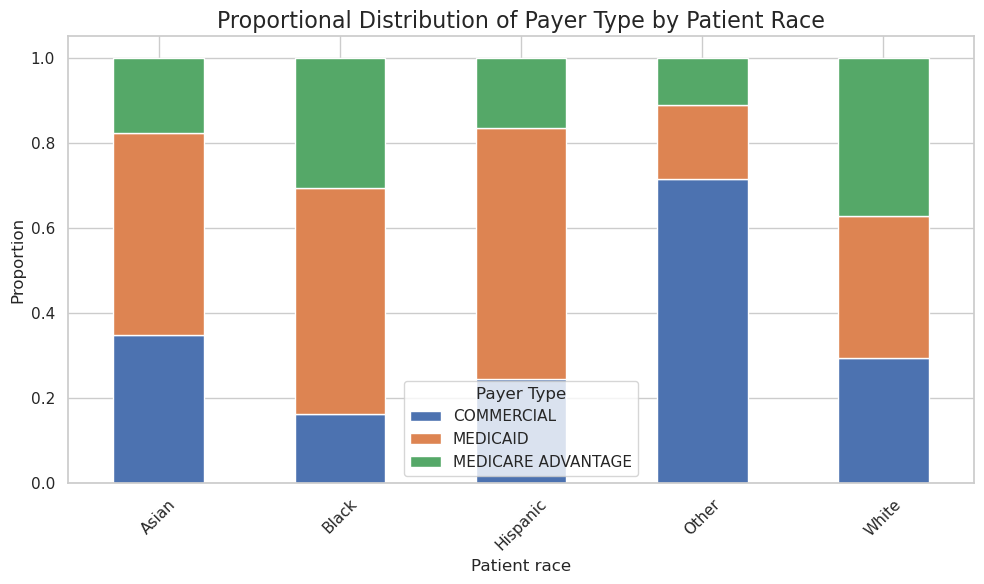

In [162]:
ct = pd.crosstab(train['patient_race'], train['payer_type'], normalize='index')

# Plotting the normalized crosstab as a proportional stacked bar chart
ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportional Distribution of Payer Type by Patient Race', fontsize=16)
plt.xlabel('Patient race', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Payer Type')
plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'images', 'stacked_bar_race_payer_type.png'))
plt.show()

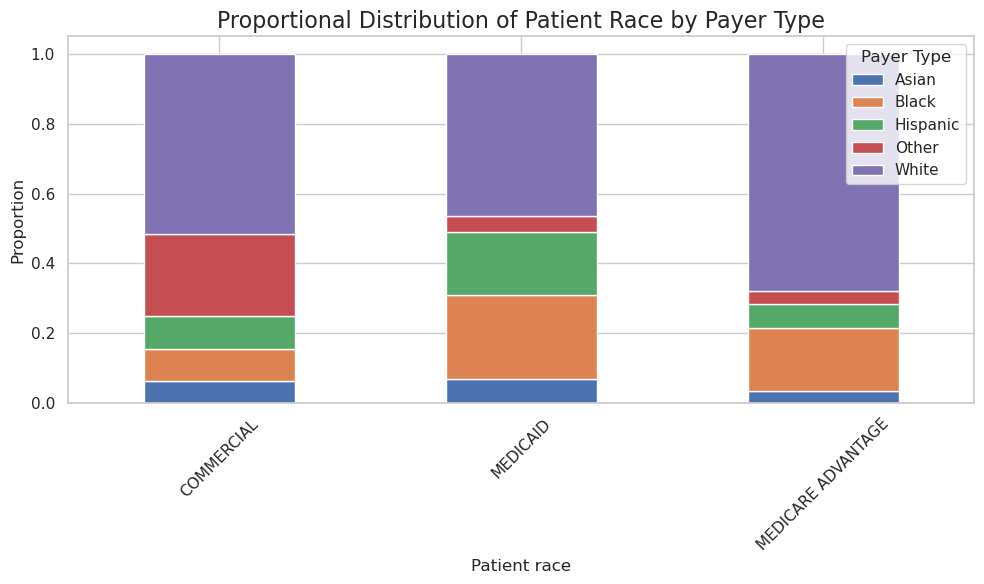

In [51]:
ct2 = pd.crosstab(train['payer_type'], train['patient_race'], normalize='index')
# Plotting the normalized crosstab as a proportional stacked bar chart
ct2.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportional Distribution of Patient Race by Payer Type', fontsize=16)
plt.xlabel('Patient race', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Payer Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'images', 'stacked_bar_race_payer_type2.png'))
plt.show()

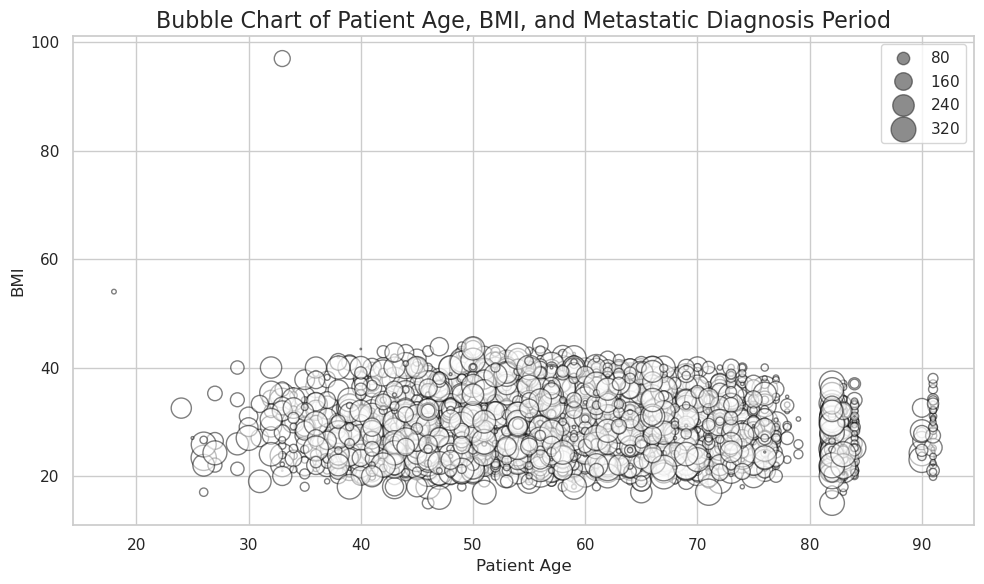

In [268]:
# Normalize the 'metastatic_diagnosis_period' for the size of the bubbles
size = train['metastatic_diagnosis_period'] / train['metastatic_diagnosis_period'].max() * 1000  # Adjust size factor

# Creating the plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train['patient_age'], train['bmi'], s=train['metastatic_diagnosis_period'], alpha=0.5, color='white', edgecolors='black')
plt.title('Bubble Chart of Patient Age, BMI, and Metastatic Diagnosis Period', fontsize=16)
plt.xlabel('Patient Age', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.legend(*scatter.legend_elements("sizes", num=6))
plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'images', 'age_bmi_mdp_scatter.png'))
plt.show()

In [269]:
train_imputed

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,metastatic_diagnosis_period,bmi_null,patient_race,payer_type,patient_state,Region,Division,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code
0,268700.0,724.0,39.0,29.690690,3924.87,82.63,42.58,11.61,13.03,10.87,...,191.0,1.0,Asian,COMMERCIAL,AR,South,West South Central,F,C50912,C773
1,484983.0,629.0,55.0,35.360000,2745.39,51.79,43.54,11.22,12.19,11.45,...,33.0,0.0,White,COMMERCIAL,IL,Midwest,East North Central,F,C50412,C773
2,277055.0,925.0,59.0,29.673514,38343.18,700.34,36.28,13.27,15.66,13.49,...,157.0,1.0,Asian,COMMERCIAL,CA,West,Pacific,F,1749,C773
3,320055.0,900.0,59.0,27.490736,36054.12,5294.33,36.65,9.76,11.27,17.23,...,146.0,1.0,Hispanic,MEDICAID,CA,West,Pacific,F,C50911,C773
4,190386.0,934.0,71.0,28.063999,13700.37,400.48,41.78,10.03,16.43,12.97,...,286.0,1.0,Asian,COMMERCIAL,CA,West,Pacific,F,1748,C7951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,588544.0,191.0,59.0,29.562971,31948.46,5512.17,35.72,10.85,10.95,18.16,...,106.0,1.0,Hispanic,MEDICAID,PA,Northeast,Middle Atlantic,F,C50911,C773
13169,393047.0,757.0,73.0,30.670000,9309.38,204.69,40.87,11.27,14.64,12.11,...,92.0,0.0,Asian,COMMERCIAL,TX,South,West South Central,F,1749,C7951
13170,790904.0,928.0,19.0,28.826262,39121.88,2295.94,38.20,11.88,13.35,14.23,...,0.0,1.0,Asian,COMMERCIAL,CA,West,Pacific,F,C50819,C799
13171,455518.0,481.0,52.0,29.361520,23266.06,743.56,41.47,10.94,13.59,12.67,...,330.0,1.0,Asian,COMMERCIAL,MI,Midwest,East North Central,F,1742,C779


In [256]:
tmp[['age_bin', 'bmi_bin']]

,age_bin,bmi_bin
1807,NaN,8
5991,8,NaN
9147,4,2


In [227]:
train.metastatic_diagnosis_period.describe()

count    13173.000000
mean        96.515221
std        108.969873
min          0.000000
25%          3.000000
50%         44.000000
75%        181.000000
max        365.000000
Name: metastatic_diagnosis_period, dtype: float64

In [238]:
train.groupby('patient_race')['bmi'].median().sort_values(ascending=False)

patient_race
Black       30.900
Hispanic    30.000
White       28.600
Other       27.195
Asian       25.000
Name: bmi, dtype: float64

In [239]:
train.groupby('patient_race')['metastatic_diagnosis_period'].median().sort_values(ascending=False)

patient_race
Other       49.5
Asian       49.0
Black       47.0
White       39.0
Hispanic    32.0
Name: metastatic_diagnosis_period, dtype: float64

In [242]:
train.groupby('patient_race')['patient_age'].median().sort_values(ascending=False)

patient_race
White       60.0
Black       59.0
Asian       58.0
Other       57.0
Hispanic    56.0
Name: patient_age, dtype: float64

In [5]:
train_imputed

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,metastatic_diagnosis_period,bmi_null,patient_race,payer_type,patient_state,Region,Division,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code
0,268700.0,724.0,39.0,29.690690,3924.87,82.63,42.58,11.61,13.03,10.87,...,191.0,1.0,Asian,COMMERCIAL,AR,South,West South Central,F,C50912,C773
1,484983.0,629.0,55.0,35.360000,2745.39,51.79,43.54,11.22,12.19,11.45,...,33.0,0.0,White,COMMERCIAL,IL,Midwest,East North Central,F,C50412,C773
2,277055.0,925.0,59.0,29.673514,38343.18,700.34,36.28,13.27,15.66,13.49,...,157.0,1.0,Asian,COMMERCIAL,CA,West,Pacific,F,1749,C773
3,320055.0,900.0,59.0,27.490736,36054.12,5294.33,36.65,9.76,11.27,17.23,...,146.0,1.0,Hispanic,MEDICAID,CA,West,Pacific,F,C50911,C773
4,190386.0,934.0,71.0,28.063999,13700.37,400.48,41.78,10.03,16.43,12.97,...,286.0,1.0,Asian,COMMERCIAL,CA,West,Pacific,F,1748,C7951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,588544.0,191.0,59.0,29.562971,31948.46,5512.17,35.72,10.85,10.95,18.16,...,106.0,1.0,Hispanic,MEDICAID,PA,Northeast,Middle Atlantic,F,C50911,C773
13169,393047.0,757.0,73.0,30.670000,9309.38,204.69,40.87,11.27,14.64,12.11,...,92.0,0.0,Asian,COMMERCIAL,TX,South,West South Central,F,1749,C7951
13170,790904.0,928.0,19.0,28.826262,39121.88,2295.94,38.20,11.88,13.35,14.23,...,0.0,1.0,Asian,COMMERCIAL,CA,West,Pacific,F,C50819,C799
13171,455518.0,481.0,52.0,29.361520,23266.06,743.56,41.47,10.94,13.59,12.67,...,330.0,1.0,Asian,COMMERCIAL,MI,Midwest,East North Central,F,1742,C779


In [27]:
def columns_containing_text(df, text):
    """
    Returns a list of column names in the DataFrame that contain the specified text.

    Parameters:
    df (pd.DataFrame): The DataFrame to search within.
    text (str): The text to search for in the DataFrame column names.

    Returns:
    list: A list of column names that contain the specified text.
    """
    return [column for column in df.columns if text in column]

In [120]:
age_cols = columns_containing_text(train_imputed, 'age_')
income_cols = columns_containing_text(train_imputed, 'income')
edu_cols = columns_containing_text(train_imputed, 'education_')
average_cols = columns_containing_text(train_imputed, 'Average')
race_cols = columns_containing_text(train_imputed, 'race_')
other_cols = ['self_employed', 'widowed', 'veteran', 'unemployment_rate', 'rent_median', 'rent_burden', 'poverty', 'population', 'male', 'female',
              'home_value', 'home_ownership', 'commute_time', 'density', 'disabled', 'married', 'divorced', 'never_married','family_size', 'farmer', 
              'health_uninsured', 'hispanic', 'housing_units', 'labor_force_participation', 'limited_english']
print(len(income_cols+age_cols+edu_cols+average_cols+race_cols+other_cols))

136


In [113]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

pca_train_data = pd.DataFrame(pca.fit_transform(train_imputed[income_cols+age_cols+edu_cols+average_cols+race_cols+other_cols]), columns=['PC'+str(i+1) for i in range(pca.n_components_)])
pca_train_data

,PC1,PC2,PC3,PC4,PC5
0,-251811.445075,-12928.488933,14248.333323,98.647860,-915.987951
1,-246710.018960,-4960.733802,13068.238020,1268.778889,-600.595629
2,55979.502134,-5153.810610,-14470.950237,-7268.142644,-911.004187
3,535464.532931,-35614.538588,12930.245011,-629.248181,2177.860138
4,265270.052575,-3752.270294,18783.163483,-4343.264749,-1125.235172
...,...,...,...,...,...
13168,-103868.309167,-9581.792943,-14137.582378,3620.998978,-115.508246
13169,-189847.179737,-2354.158289,7029.437226,-687.877026,-1121.930969
13170,341982.567677,4831.200585,-8978.027395,-7155.374390,-1831.764306
13171,-118645.500919,7560.084176,-9613.208649,154.906720,803.799638


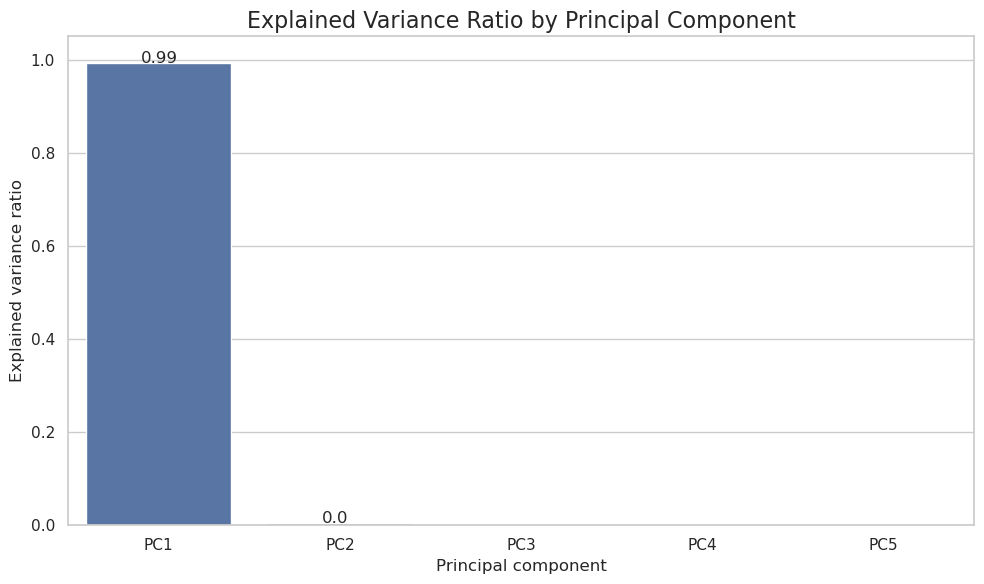

In [114]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=['PC'+str(i+1) for i in range(len(pca.explained_variance_ratio_))], y=pca.explained_variance_ratio_)
for i , evri in enumerate(pca.explained_variance_ratio_[:2]):
    ax.text(i-0.1, evri, np.round(evri, 2), fontdict={'fontsize':12})
ax.set_ylim(0, 1.05)
ax.set_title('Explained Variance Ratio by Principal Component', fontsize=16)
ax.set_xlabel('Principal component', fontsize=12)
ax.set_ylabel('Explained variance ratio', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'explained_variance_ratio.png'))
plt.show()

In [115]:
pca_test_data = pd.DataFrame(pca.transform(test_imputed[income_cols+age_cols+edu_cols+average_cols+race_cols+other_cols]), columns=['PC'+str(i+1) for i in range(pca.n_components_)])
pca_test_data.head()

,PC1,PC2,PC3,PC4,PC5
0,-225515.974366,-18302.908708,16165.583689,-124.301607,-528.343058
1,-219127.467459,-11088.235978,7045.176058,-331.267302,-276.153148
2,-212937.914738,-15954.773106,-49.404249,-1323.553906,-498.110788
3,-168769.949875,-8280.635411,11351.094810,-1354.216930,-1336.421874
4,348995.151343,28352.053570,-5969.441163,479.697267,2576.197835


In [132]:
train_pca = train_imputed.drop(columns=income_cols+age_cols+edu_cols+average_cols+race_cols+other_cols+['patient_gender', 'patient_id', 'bmi_null'])
train_pca['PC1'] = pca_train_data['PC1'].copy()
train_pca.head()

,patient_zip3,patient_age,bmi,metastatic_diagnosis_period,patient_race,payer_type,patient_state,Region,Division,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,PC1
0,724.0,39.0,29.690690,191.0,Asian,COMMERCIAL,AR,South,West South Central,C50912,C773,-251811.445075
1,629.0,55.0,35.360000,33.0,White,COMMERCIAL,IL,Midwest,East North Central,C50412,C773,-246710.018960
2,925.0,59.0,29.673514,157.0,Asian,COMMERCIAL,CA,West,Pacific,1749,C773,55979.502134
3,900.0,59.0,27.490736,146.0,Hispanic,MEDICAID,CA,West,Pacific,C50911,C773,535464.532931
4,934.0,71.0,28.063999,286.0,Asian,COMMERCIAL,CA,West,Pacific,1748,C7951,265270.052575


In [133]:
test_pca = test_imputed.drop(columns=income_cols+age_cols+edu_cols+average_cols+race_cols+other_cols+['patient_gender', 'patient_id'])
test_pca['PC1'] = pca_test_data['PC1'].copy()
test_pca.head()

,patient_zip3,patient_age,bmi,patient_race,payer_type,patient_state,Region,Division,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,PC1
0,713.0,55.0,29.833906,Asian,COMMERCIAL,LA,South,West South Central,1746,C7981,-225515.974366
1,283.0,60.0,40.000000,Black,COMMERCIAL,NC,South,South Atlantic,C50912,C773,-219127.467459
2,794.0,54.0,32.330000,Asian,COMMERCIAL,TX,South,West South Central,1742,C773,-212937.914738
3,373.0,63.0,27.070000,Asian,COMMERCIAL,TN,South,East South Central,1748,C7951,-168769.949875
4,980.0,62.0,28.139801,Asian,COMMERCIAL,WA,West,Pacific,C50411,C787,348995.151343


In [138]:
train_pca.to_csv('train_pca.csv', index=False)
test_pca.to_csv('test_pca.csv', index=False)

In [8]:
train_pca = pd.read_csv('train_pca.csv')
test_pca = pd.read_csv('test_pca.csv')

In [5]:
print(f"Shape: {train_pca.shape}")
train_pca.head()

Shape: (13173, 12)


,patient_zip3,patient_age,bmi,metastatic_diagnosis_period,patient_race,payer_type,patient_state,Region,Division,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,PC1
0,724.0,39.0,29.690690,191.0,Asian,COMMERCIAL,AR,South,West South Central,C50912,C773,-251811.445075
1,629.0,55.0,35.360000,33.0,White,COMMERCIAL,IL,Midwest,East North Central,C50412,C773,-246710.018960
2,925.0,59.0,29.673514,157.0,Asian,COMMERCIAL,CA,West,Pacific,1749,C773,55979.502134
3,900.0,59.0,27.490736,146.0,Hispanic,MEDICAID,CA,West,Pacific,C50911,C773,535464.532931
4,934.0,71.0,28.063999,286.0,Asian,COMMERCIAL,CA,West,Pacific,1748,C7951,265270.052575


In [9]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.preprocessor = None
        self.columns = None
        self.cat_columns = None
        self.num_columns = None

    def fit(self, X, y=None):
        self.columns = X.columns
        self.cat_columns = X.select_dtypes(include=['object', 'category']).columns
        self.num_columns = X.select_dtypes(include=[np.number]).columns
        
        # Define the column transformer
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.num_columns),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), self.cat_columns)
            ])
        
        # Fit the column transformer
        self.preprocessor.fit(X)
        
        return self

    def transform(self, X):
        X_transformed = self.preprocessor.transform(X)
        
        # Get feature names for both numerical and categorical features
        num_features = self.num_columns
        cat_features = self.preprocessor.named_transformers_['cat'].get_feature_names_out(self.cat_columns)
        all_features = np.concatenate([num_features, cat_features])
        # print(len(all_features))
        
        X_transformed = pd.DataFrame(X_transformed, columns=all_features)
        
        return X_transformed

In [10]:
X = train_pca.drop(columns=['metastatic_diagnosis_period'])
y = train_pca['metastatic_diagnosis_period']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

transformer = CustomTransformer()
X_train = transformer.fit_transform(X_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (7903, 153)
X_val.shape: (2635, 153)
X_test.shape: (2635, 153)
y_train.shape: (7903,)
y_val.shape: (2635,)
y_test.shape: (2635,)


In [15]:
X.shape

(13173, 11)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
class RegressionEvaluator:
    def __init__(self, models):
        self.models = models
        self.results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R-Squared'])

    def fit_and_evaluate(self, X_train, y_train, X_val, y_val):
        for name, model in self.models.items():
            model.fit(X_train, y_train)
            predictions = model.predict(X_val)
            
            mse = mean_squared_error(y_val, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_val, predictions)
            r2 = r2_score(y_val, predictions)
            
            self.results = self.results.append({
                'Model': name,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R-Squared': r2
            }, ignore_index=True)
        
        return self.results

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from catboost import CatBoostRegressor 


In [17]:
models.keys()

dict_keys(['Linear Regression', 'Support Vector Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'AdaBoost Regressor', 'MLP Regressor', 'XGB Regressor', 'CatBoost Regressor'])

In [71]:
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Regressor': SVR(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'MLP Regressor': MLPRegressor(),
    'XGB Regressor': xgb.XGBRegressor(),
    'CatBoost Regressor': CatBoostRegressor()
}

reg_evaluator = RegressionEvaluator(models=models)
results = reg_evaluator.fit_and_evaluate(X_train, y_train, X_val, y_val)

/tmp/ipykernel_786606/1499192003.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_786606/1499192003.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_786606/1499192003.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_786606/1499192003.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_786606/1499192003.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/georgetz/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/tmp/ipykernel_786606/1499192003.py:17: FutureWarning:

The fra

Learning rate set to 0.058159
0:	learn: 106.9020037	total: 48ms	remaining: 48s
1:	learn: 104.8352198	total: 49.3ms	remaining: 24.6s
2:	learn: 102.9713297	total: 50.7ms	remaining: 16.8s
3:	learn: 101.2793811	total: 53.4ms	remaining: 13.3s
4:	learn: 99.7602551	total: 55.1ms	remaining: 11s
5:	learn: 98.2040115	total: 56.5ms	remaining: 9.35s
6:	learn: 96.9560489	total: 60.2ms	remaining: 8.54s
7:	learn: 95.7538465	total: 61.8ms	remaining: 7.67s
8:	learn: 94.6440541	total: 63.2ms	remaining: 6.96s
9:	learn: 93.5887460	total: 66.6ms	remaining: 6.59s
10:	learn: 92.5456133	total: 68.1ms	remaining: 6.13s
11:	learn: 91.8832173	total: 69.5ms	remaining: 5.72s
12:	learn: 91.1025072	total: 72ms	remaining: 5.47s
13:	learn: 90.4153450	total: 73.4ms	remaining: 5.17s
14:	learn: 89.8387035	total: 75ms	remaining: 4.92s
15:	learn: 89.2122251	total: 76.4ms	remaining: 4.7s
16:	learn: 88.6484124	total: 78.5ms	remaining: 4.54s
17:	learn: 88.1625382	total: 79.9ms	remaining: 4.36s
18:	learn: 87.7873233	total: 81.3

/tmp/ipykernel_786606/1499192003.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [94]:
pd.options.display.float_format = '{:.6f}'.format
results.sort_values(by='RMSE', ascending=True)

,Model,MSE,RMSE,MAE,R-Squared
3,Gradient Boosting Regressor,6853.742064,82.787330,64.398887,0.417921
5,MLP Regressor,6866.455521,82.864079,62.734994,0.416841
7,CatBoost Regressor,6873.768294,82.908192,63.199671,0.416220
2,Random Forest Regressor,7187.994678,84.782042,64.256346,0.389533
6,XGB Regressor,7278.157429,85.312118,64.782278,0.381875
4,AdaBoost Regressor,8000.410076,89.445011,76.524780,0.320536
1,Support Vector Regressor,12047.026631,109.758948,77.223250,-0.023138
0,Linear Regression,1490075225960355463168.000000,38601492535.397583,1063546009.906780,-126550163976675456.000000


In [95]:
results.sort_values(by='RMSE', ascending=True).to_csv('results.csv', index=False)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin


In [11]:

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Create the GradientBoostingRegressor model
gbr = GradientBoostingRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END l

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [13]:
X_train

,patient_zip3,patient_age,bmi,PC1,patient_race_Asian,patient_race_Black,patient_race_Hispanic,patient_race_Other,patient_race_White,payer_type_COMMERCIAL,...,metastatic_cancer_diagnosis_code_C7961,metastatic_cancer_diagnosis_code_C7962,metastatic_cancer_diagnosis_code_C7970,metastatic_cancer_diagnosis_code_C7971,metastatic_cancer_diagnosis_code_C7972,metastatic_cancer_diagnosis_code_C798,metastatic_cancer_diagnosis_code_C7981,metastatic_cancer_diagnosis_code_C7982,metastatic_cancer_diagnosis_code_C7989,metastatic_cancer_diagnosis_code_C799
0,-1.554938,0.527205,0.168500,-0.668162,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.963069,0.068970,-0.152349,0.134754,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.750809,0.450832,0.170632,-0.596438,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.407511,-0.771127,0.250361,-0.867124,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.418405,-1.763968,-1.234736,-0.745387,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7898,0.587409,-0.160147,0.175512,-0.745773,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7899,-1.046584,1.901908,0.162534,-0.630090,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7900,-0.843243,-0.923872,0.132520,-0.222915,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7901,-0.821456,-0.465637,-0.077189,0.039015,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
import pickle
# Save the entire GridSearchCV object to a pickle file
with open('grid_search_gbr.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

In [7]:
import pickle
with open('grid_search_gbr.pkl', 'rb') as f:
    grid_search = pickle.load(f)

In [14]:
grid_search

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 500],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [15]:
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)
train_pred = final_model.predict(X_train)
val_pred = final_model.predict(X_val)
test_pred = final_model.predict(X_test)

In [18]:
final_results = pd.DataFrame({'MSE': [mean_squared_error(x, y) for x, y in zip([y_train, y_val, y_test], [train_pred, val_pred, test_pred])],
              'RMSE': [np.sqrt(mean_squared_error(x, y)) for x, y in zip([y_train, y_val, y_test], [train_pred, val_pred, test_pred])],
              'MAE': [mean_absolute_error(x, y) for x, y in zip([y_train, y_val, y_test], [train_pred, val_pred, test_pred])],
              'R-Squared': [r2_score(x, y) for x, y in zip([y_train, y_val, y_test], [train_pred, val_pred, test_pred])]}, index=['Train', 'Validation', 'Test'])
final_results

,MSE,RMSE,MAE,R-Squared
Train,6256.934807,79.100789,61.199435,0.479690
Validation,6407.817329,80.048843,62.077509,0.451781
Test,6778.993597,82.334644,63.136568,0.415252


In [19]:
final_results.to_csv('final_results.csv')

In [37]:
[i.split(':')[0].strip() for i in desc.split('\n')]

['learning_rate',
 'max_depth',
 'max_features',
 'min_samples_leaf',
 'min_samples_split',
 'n_estimators',
 'subsample']

In [41]:
desc = """learning_rate: This parameter scales the contribution of each tree in the ensemble. A smaller learning rate means that more trees are needed to build a model of similar complexity. It's often used to balance the model's accuracy versus its generalization. In your case, 0.05 is a relatively small learning rate, promoting more robust learning but requiring potentially more trees to converge to a good solution.
max_depth: This limits the maximum depth of each tree. Deeper trees can learn more detailed data specifics, enhancing the model's ability to fit complex patterns, but they also increase the risk of overfitting. A depth of 3 is conservative, aiming to keep the model general enough.
max_features: Determines the number of features to consider when looking for the best split. If None, then all features are considered each time a split is made, which can lead to more computationally intensive and deeper trees.
min_samples_leaf: The minimum number of samples required to be at a leaf node. Setting this parameter can help prevent overfitting by ensuring that leaves have more than just a few data points. In your configuration, each leaf must have at least 4 samples.
min_samples_split: The minimum number of samples required to split an internal node. A higher number makes the model more conservative because it's less likely to create highly specific splits. Your setting of 5 means each internal node must have at least 5 samples before it can be split.
n_estimators: This is the number of sequential trees to be modeled. While more trees generally improve the model, they also make your model slower to train. An n_estimators value of 300 is relatively high, potentially providing a more accurate model at the cost of increased computational time.
subsample: The fraction of samples to be used for fitting each individual base learner. Using a subsample (less than 1.0) introduces more randomness into the model, can lead to lower variance, and can speed up training significantly. 0.8 means 80% of the data is used for each tree, which can help in preventing overfitting by adding more diversity to the trees built during training."""

pd.DataFrame({'Hyperparameter': [i.split(':')[0].strip() for i in desc.split('\n')], 'Description': [i.split(':')[1].strip() for i in desc.split('\n')]}).to_csv('hyperparameter_desc.csv', index=False)

In [32]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 300,
 'subsample': 0.8}

In [25]:
feature_imp_df = pd.DataFrame({'Feature': final_model.feature_names_in_, 'Importance': final_model.feature_importances_}).sort_values(by='Importance', ascending=False)
feature_imp_df

,Feature,Importance
75,breast_cancer_diagnosis_code_1749,0.478416
71,breast_cancer_diagnosis_code_1744,0.121417
74,breast_cancer_diagnosis_code_1748,0.106047
1,patient_age,0.035121
69,breast_cancer_diagnosis_code_1742,0.034390
...,...,...
107,breast_cancer_diagnosis_code_C5091,0.000000
111,breast_cancer_diagnosis_code_C50922,0.000000
116,metastatic_cancer_diagnosis_code_C774,0.000000
117,metastatic_cancer_diagnosis_code_C775,0.000000


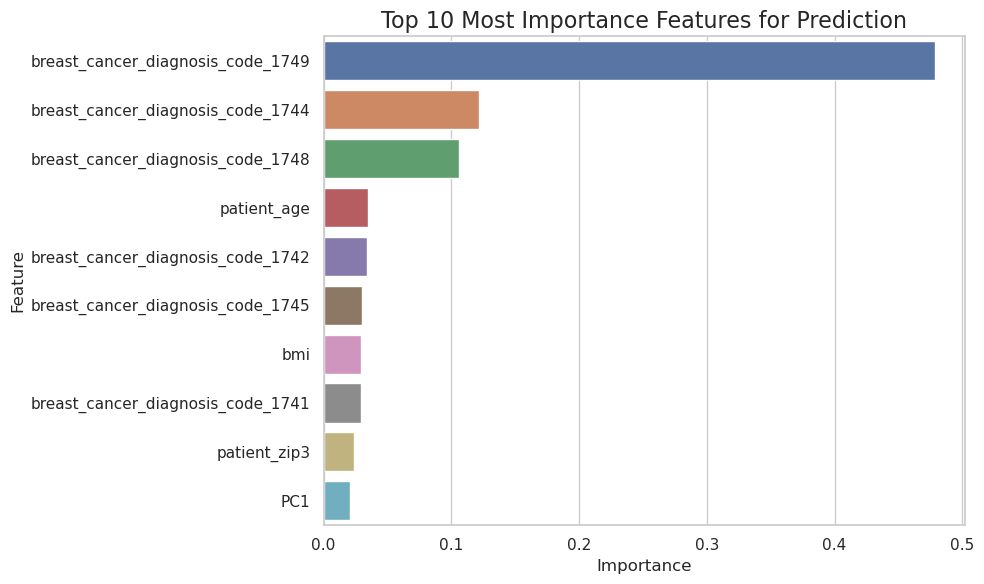

In [26]:
top_features = feature_imp_df[:10]
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=top_features, y='Feature', x='Importance')
ax.set_title('Top 10 Most Importance Features for Prediction', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'feature_importance.png'))
plt.show()

In [29]:
breast_cancer_diagnosis_df[breast_cancer_diagnosis_df.breast_cancer_diagnosis_code == '1749']

,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc
2,1749,"Malignant neoplasm of breast (female), unspeci..."


/home/georgetz/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead



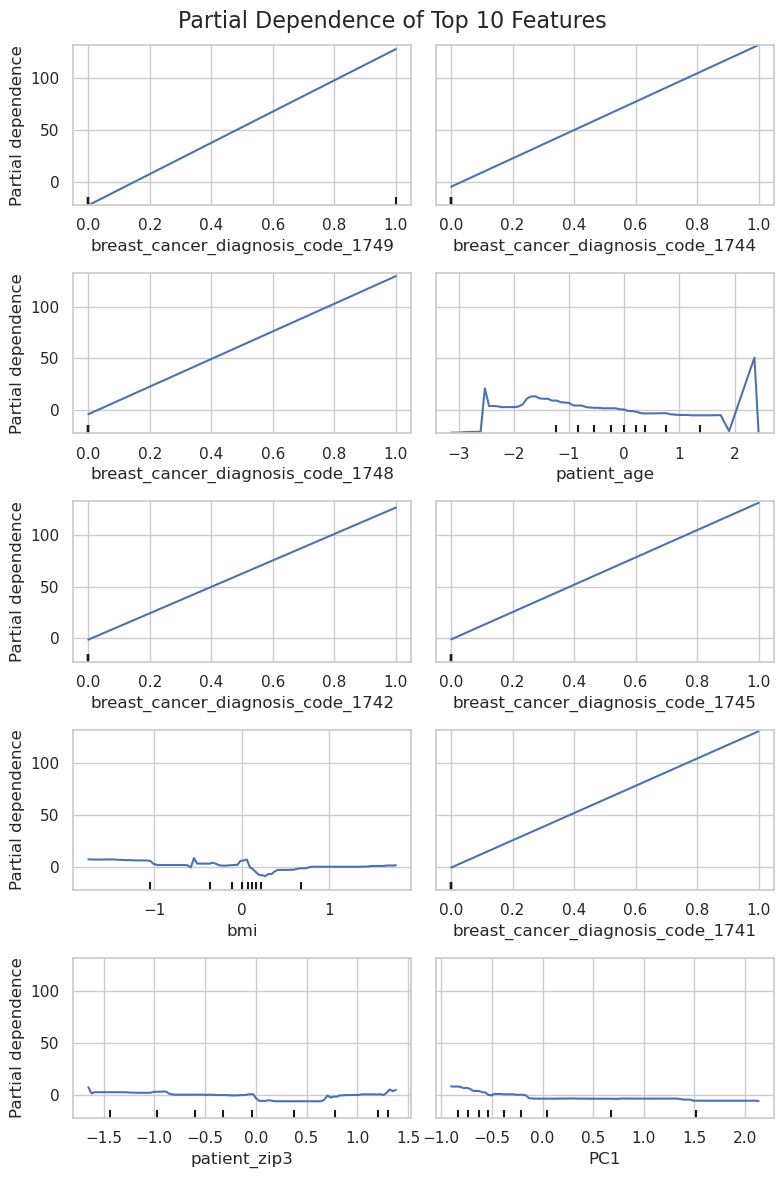

In [28]:
from sklearn.inspection import plot_partial_dependence
features_to_plot = feature_imp_df[:10]['Feature'].values
fig, ax = plt.subplots(5,2,figsize=(8,12))
plot_partial_dependence(final_model, X_train, features=features_to_plot, grid_resolution=100, n_cols=2, ax=ax)
fig.suptitle('Partial Dependence of Top 10 Features', fontsize=16)
fig.tight_layout()
fig.savefig(os.path.join(DATA_PATH, 'images', 'partial_dependence_plot.png'))
plt.show()

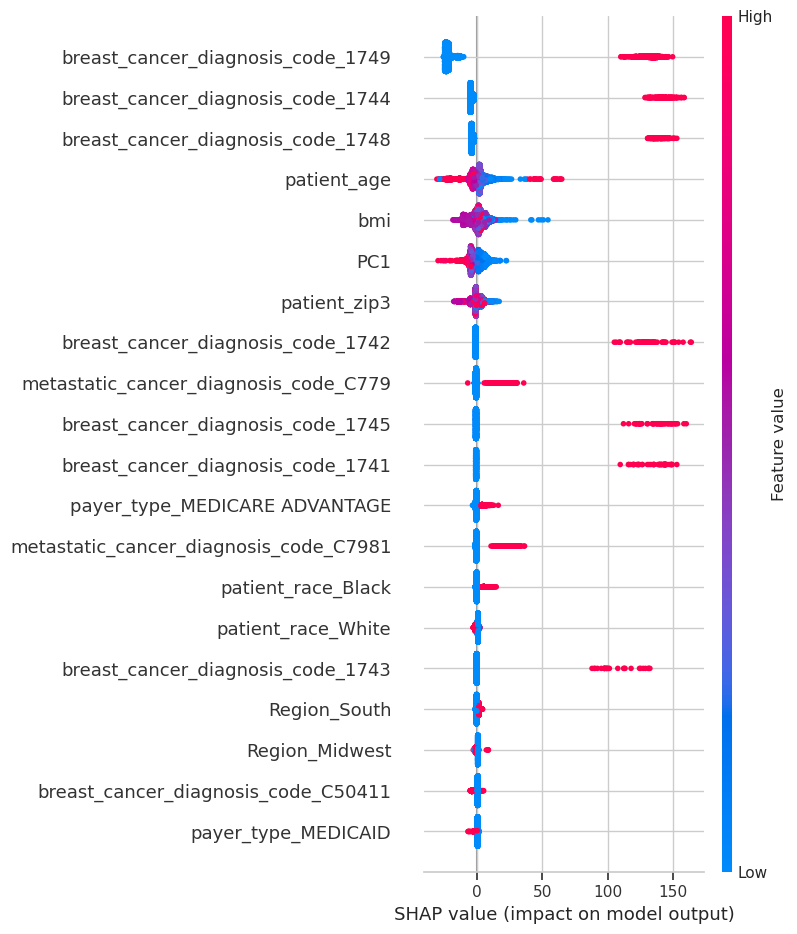

In [29]:
import shap
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig(os.path.join(DATA_PATH, 'images', 'shap_summary_plot.png'), bbox_inches='tight')

In [30]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 300,
 'subsample': 0.8}